In [7]:
import pandas as pd # Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score
import xgboost as xgb

In [8]:
from google.colab import drive # Load the test dataset
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Part A: Model Code and Exploration (100 pts)

In [9]:
# read CSV
df_dt= pd.read_csv("/content/drive/MyDrive/capstone_yb/ ML/Data/8k_diabetes_train.csv")

In [10]:
# Display the first few rows of the dataset
print("First few rows of the dataset:")
df_dt.head()
#df_diatbete.sample(5)# random 5 samples

First few rows of the dataset:


,discharge_disposition_id,admission_source_id,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_diagnoses,...,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted,2nd_diag,3rd_diag,ai_response
0,Discharged to home,Transfer from a hospital,?,?,24,2,17,0,0,8,...,No,No,No,No,No,Yes,False,414,428,"Based on the diagnosis code 250.01, which indi..."
1,Discharged to home,Transfer from a hospital,?,?,37,3,14,0,0,8,...,No,No,No,No,No,Yes,False,410,414,"Based on the information provided, I recommend..."
2,Discharged to home,Emergency Room,SP,Emergency/Trauma,60,4,17,0,0,9,...,No,No,No,No,No,No,True,537,786,"Based on the information provided, the patient..."
3,Discharged to home,Emergency Room,?,?,40,3,25,1,0,9,...,No,No,No,No,Ch,Yes,True,425,428,"Based on the information provided, the patient..."
4,Discharged to home,Physician Referral,MD,Surgery-General,31,2,18,0,0,7,...,No,No,No,No,No,Yes,True,682,998,"Based on the information provided, the patient..."


## 1. Perform Exploratory Data Analysis (EDA) and discuss the data and what you observe prior to beginning modeling and how impact how to proceed [10 pts]

## 3. Pre-processed numerical data appropriately including handling missing data and justified methods used. Note this may be different for each algorithm you try. [10 pts]

###Distribution of the Target Variable (readmitted)

In [11]:
target_distribution=df_dt['readmitted'].value_counts(normalize=True)* 100
print("target Distribution: ")
print(target_distribution)

target Distribution: 
readmitted
False    59.875
True     40.125
Name: proportion, dtype: float64


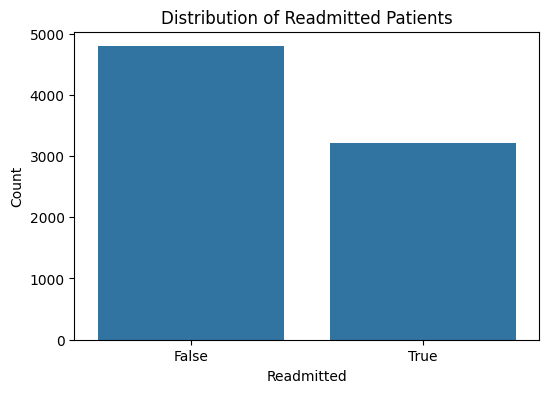

Class Distribution:
readmitted
False    4790
True     3210
Name: count, dtype: int64


In [12]:
#  Target Variable(readmitted)
target_distribution = df_dt['readmitted'].value_counts()


plt.figure(figsize=(6, 4))
sns.countplot(x='readmitted', data=df_dt)
plt.title('Distribution of Readmitted Patients')
plt.xlabel('Readmitted')
plt.ylabel('Count')
plt.show()
print("Class Distribution:")
print(target_distribution)


### Missing Value Proportions

Approximately 93.33% of max_glu_serum's values are missing, which makes handling this variable difficult. Additionally, missing data are displayed for admission_source_id and discharge_disposition_id, with proportions of roughly 9.4% and 4.55%, respectively.

In [13]:
# Check the data types
df_dt.info()
print(df_dt.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   discharge_disposition_id  7636 non-null   object
 1   admission_source_id       7248 non-null   object
 2   payer_code                8000 non-null   object
 3   medical_specialty         8000 non-null   object
 4   num_lab_procedures        8000 non-null   int64 
 5   num_procedures            8000 non-null   int64 
 6   num_medications           8000 non-null   int64 
 7   number_outpatient         8000 non-null   int64 
 8   number_emergency          8000 non-null   int64 
 9   number_diagnoses          8000 non-null   int64 
 10  max_glu_serum             534 non-null    object
 11  metformin                 8000 non-null   object
 12  repaglinide               8000 non-null   object
 13  nateglinide               8000 non-null   object
 14  chlorpropamide          

In [14]:
# Make a copy of the dataframe with a new name # Data preprocessing
df_mod_dt = df_dt.copy()

# Replace "?" with NaN
df_mod_dt.replace("?", np.nan, inplace=True)

# Check the modified dataframe
df_mod_dt.head()

# check is null
df_mod_dt.isnull().sum()

discharge_disposition_id     364
admission_source_id          752
payer_code                  4302
medical_specialty           3278
num_lab_procedures             0
num_procedures                 0
num_medications                0
number_outpatient              0
number_emergency               0
number_diagnoses               0
max_glu_serum               7466
metformin                      0
repaglinide                    0
nateglinide                    0
chlorpropamide                 0
glimepiride                    0
acetohexamide                  0
glipizide                      0
glyburide                      0
tolbutamide                    0
pioglitazone                   0
rosiglitazone                  0
acarbose                       0
miglitol                       0
troglitazone                   0
tolazamide                     0
examide                        0
citoglipton                    0
insulin                        0
glyburide.metformin            0
glipizide.

I want to delete 'max_glu_serum' because they have lots missings.

'max_glu_serum'              7466



In [15]:
# Specify columns of interest
columns_of_interest = ['discharge_disposition_id', 'admission_source_id', 'payer_code', 'medical_specialty',
                       'max_glu_serum', '2nd_diag', '3rd_diag']

# Check the number of null values in specified columns
print(df_mod_dt[columns_of_interest].isnull().sum())


discharge_disposition_id     364
admission_source_id          752
payer_code                  4302
medical_specialty           3278
max_glu_serum               7466
2nd_diag                      42
3rd_diag                     169
dtype: int64


In [16]:
# Randomly sample 5 rows from each column
random_samples = df_mod_dt[columns_of_interest].sample(20)

# Print the random samples
random_samples

,discharge_disposition_id,admission_source_id,payer_code,medical_specialty,max_glu_serum,2nd_diag,3rd_diag
3334,Discharged to home,Physician Referral,MC,Radiologist,NaN,427,717
5320,Discharged to home,Transfer from a hospital,MD,NaN,NaN,305,401
4066,Discharged/transferred to home with home healt...,Emergency Room,MC,NaN,NaN,428,599
1915,Discharged to home,Emergency Room,NaN,NaN,NaN,401,428
1262,Discharged to home,Emergency Room,MC,InternalMedicine,NaN,780,998
128,Discharged to home,Emergency Room,NaN,NaN,NaN,434,571
1778,NaN,Emergency Room,NaN,NaN,NaN,250.22,590
505,Discharged to home,Emergency Room,HM,NaN,NaN,577,599
4278,Discharged to home,Emergency Room,BC,NaN,NaN,435,496
2544,Discharged to home,Physician Referral,NaN,Cardiology,NaN,411,414


In [17]:
# Convert '2nd_diag' and '3rd_diag' columns to numeric
df_mod_dt['2nd_diag'] = pd.to_numeric(df_mod_dt['2nd_diag'], errors='coerce')
df_mod_dt['3rd_diag'] = pd.to_numeric(df_mod_dt['3rd_diag'], errors='coerce')
# Calculate mean of '2nd_diag' and '3rd_diag' columns
mean_2nd_diag = df_mod_dt['2nd_diag'].mean()
mean_3rd_diag = df_mod_dt['3rd_diag'].mean()
# Replace null values with mean
df_mod_dt['2nd_diag'].fillna(mean_2nd_diag, inplace=True)
df_mod_dt['3rd_diag'].fillna(mean_3rd_diag, inplace=True)
df_mod_dt['change'] = df_mod_dt['change'].replace('Ch', 'Yes')
# Handling Missing Values
# 1. Deletion: Columns with a large number of missing values can be dropped.
#    For example,  'max_glu_serum' column may be removed due to a large number of missing values.
df_mod_dt.drop(columns=[ 'max_glu_serum'], inplace=True)

#Replace missing values with 'Unknown'
df_mod_dt['discharge_disposition_id'].fillna('Unknown', inplace=True)
df_mod_dt['admission_source_id'].fillna('Not Mapped', inplace=True) #Not Mapped= Unknown
df_mod_dt['medical_specialty'].fillna('Unknown', inplace=True)
df_mod_dt['payer_code'].fillna('Unknown', inplace=True)

# Check for missing values after processing
print(df_mod_dt.isnull().sum())

discharge_disposition_id    0
admission_source_id         0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_diagnoses            0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide                  0
examide                     0
citoglipton                 0
insulin                     0
glyburide.metformin         0
glipizide.metformin         0
glimepiride.pioglitazone    0
metformin.rosiglitazone     0
metformin.pioglitazone      0
change    

In [18]:
# Assign df_modified_dt to df2
df2 = df_mod_dt
# check unique values
stats = {"has_value":df2.isnull().count(),
         "unique_vals": [len(df2[col].unique()) for col in list(df2)]}

stats_df = pd.DataFrame(stats)

stats_df

,has_value,unique_vals
discharge_disposition_id,8000,20
admission_source_id,8000,10
payer_code,8000,16
medical_specialty,8000,52
num_lab_procedures,8000,107
num_procedures,8000,7
num_medications,8000,65
number_outpatient,8000,19
number_emergency,8000,10
number_diagnoses,8000,9


In [19]:
# Drop columns with one value
df3 = df2.drop(columns=['acetohexamide', 'troglitazone', 'examide', 'citoglipton', 'glimepiride.pioglitazone', 'metformin.rosiglitazone', 'metformin.pioglitazone'])

In [20]:
# check unique values
stats = {"has_value":df3.isnull().count(),
         "unique_vals": [len(df3[col].unique()) for col in list(df3)]}

stats_df2 = pd.DataFrame(stats)

stats_df2

,has_value,unique_vals
discharge_disposition_id,8000,20
admission_source_id,8000,10
payer_code,8000,16
medical_specialty,8000,52
num_lab_procedures,8000,107
num_procedures,8000,7
num_medications,8000,65
number_outpatient,8000,19
number_emergency,8000,10
number_diagnoses,8000,9


### Distribution and Unique Values in Categorical Variable
Most categorical variables have values like 'No', 'Steady', 'Up', 'Down', indicating changes in medication usage. Variables such as medical_specialty have a wide range of unique values, some of which are rare, indicating a high cardinality that needs to be addressed in modeling.

In [21]:
# Unique values and value counts for categorical variables
for column in df3.select_dtypes(include=['object']).columns:
    print(f"Unique values for {column}: {df3[column].unique()}")
    print(f"Value counts for {column}:")
    print(df3[column].value_counts())

Unique values for discharge_disposition_id: ['Discharged to home'
 'Discharged/transferred to home with home health service'
 'Discharged/transferred to SNF' 'Not Mapped'
 'Discharged/transferred to another  type of inpatient care institution'
 'Discharged/transferred to another short term hospital' 'Unknown'
 'Expired'
 'Discharged/transferred to another rehab fac including rehab units of a hospital.'
 'Left AMA'
 'Discharged/transferred/referred to a psychiatric hospital of a psychiatric distinct part unit of a hospital'
 'Discharged/transferred to a long term care hospital.' 'Hospice / home'
 'Discharged/transferred to home under care of Home IV provider'
 'Discharged/transferred to ICF'
 'Discharged/transferred/referred to this institution for outpatient services'
 'Hospice / medical facility' 'Admitted as an inpatient to this hospital'
 'Discharged/transferred/referred another institution for outpatient services'
 'Discharged/transferred within this institution to Medicare approve

### Descriptive Statistics for Numerical Variables

The ranges of numerical variables indicate that some may require standardization or normalization. For instance, num_medications displays an average of 16 prescriptions written for each patient,whereas num_lab_procedures indicates an average of roughly 43 lab operations per patient.

In [22]:
# Check summary statistics of numerical columns
print(df3.describe())

       num_lab_procedures  num_procedures  num_medications  number_outpatient  \
count         8000.000000     8000.000000      8000.000000        8000.000000   
mean            43.183375        1.391750        15.543375           0.280875   
std             19.518187        1.709575         8.398151           1.075932   
min              1.000000        0.000000         1.000000           0.000000   
25%             32.000000        0.000000        10.000000           0.000000   
50%             44.000000        1.000000        14.000000           0.000000   
75%             57.000000        2.000000        19.000000           0.000000   
max            120.000000        6.000000        75.000000          36.000000   

       number_emergency  number_diagnoses     2nd_diag     3rd_diag  
count       8000.000000       8000.000000  8000.000000  8000.000000  
mean           0.108375          7.027875   451.848064   586.283537  
std            0.467608          2.019680   154.565850   178

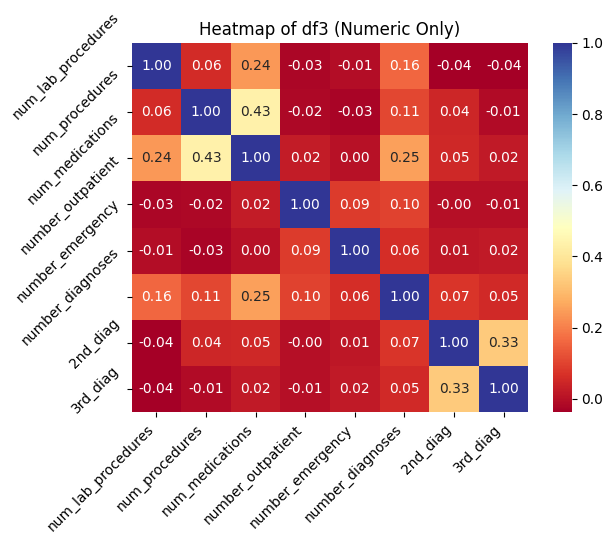

In [23]:
# Create a new DataFrame with only numeric columns from df3
df3_numeric = df3.select_dtypes(include=[np.number])

# Calculate the correlation matrix for the numeric DataFrame
corr_numeric = df3_numeric.corr()

# Create a heatmap for the correlation matrix
sns.heatmap(corr_numeric,
            xticklabels=corr_numeric.columns,
            yticklabels=corr_numeric.columns,
            cmap='RdYlBu',  # Color palette for the heatmap
            annot=True,    # Annotate cells with correlation values
            fmt=".2f")     # Format for the annotation text

# Adjust layout for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.title('Heatmap of df3 (Numeric Only)')
plt.show()


From the heatmap, the value of 0.43 indicates a moderate positive correlation between num_medications and num_procedures

##2. Pre-processed categorical data for use in the model and justified pre-processing method. Note this may be different for each algorithm you try. [10 pts]


In the preprocessing of categorical data, I utilized one-hot encoding for categorical variables. This approach enables the model to interpret categorical data effectively, transforming each category into a separate feature. Additionally, binary data such as 'change' and 'diabetesMed' have been converted into 0s and 1s, and the target variable 'readmitted' has been similarly transformed to facilitate a binary classification problem setup.

In [24]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
le = LabelEncoder()

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df3, columns=['repaglinide', 'nateglinide','chlorpropamide', 'glimepiride',
                                          'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone','acarbose',
                                          'miglitol', 'tolazamide', 'insulin', 'glyburide.metformin', 'glipizide.metformin','metformin',])
# 'discharge_disposition_id' label encoding
df_encoded['discharge_disposition_id'] = le.fit_transform(df_encoded['discharge_disposition_id'])
df_encoded['admission_source_id'] = le.fit_transform(df_encoded['admission_source_id'])
df_encoded['payer_code'] = le.fit_transform(df_encoded['payer_code'])
df_encoded['medical_specialty'] = le.fit_transform(df_encoded['medical_specialty'])

# Binary data transformation
df_encoded['change'] = df_encoded['change'].map({'Yes': 1, 'No': 0})
df_encoded['diabetesMed'] = df_encoded['diabetesMed'].map({'Yes': 1, 'No': 0})
# Convert target
df_encoded['readmitted'] = df_encoded['readmitted'].apply(lambda x: 1 if x==True else 0)
df_encoded

,discharge_disposition_id,admission_source_id,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_diagnoses,...,glyburide.metformin_Down,glyburide.metformin_No,glyburide.metformin_Steady,glyburide.metformin_Up,glipizide.metformin_No,glipizide.metformin_Steady,metformin_Down,metformin_No,metformin_Steady,metformin_Up
0,1,8,14,50,24,2,17,0,0,8,...,False,True,False,False,True,False,False,True,False,False
1,1,8,14,50,37,3,14,0,0,8,...,False,True,False,False,True,False,False,True,False,False
2,1,2,12,3,60,4,17,0,0,9,...,False,True,False,False,True,False,False,True,False,False
3,1,2,14,50,40,3,25,1,0,9,...,False,True,False,False,True,False,False,True,False,False
4,1,6,7,43,31,2,18,0,0,7,...,False,True,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,1,9,5,50,52,0,7,0,0,5,...,False,True,False,False,True,False,False,True,False,False
7996,1,2,6,50,64,0,12,7,0,9,...,False,True,False,False,True,False,False,False,True,False
7997,1,2,6,50,40,1,10,0,0,9,...,False,True,False,False,True,False,False,True,False,False
7998,9,2,14,50,31,0,12,0,0,4,...,False,True,False,False,True,False,False,True,False,False


##3. Pre-processed numerical data appropriately including handling missing data and justified methods used. Note this may be different for each algorithm you try. [10 pts]


The prior section addressed missing data.
I divided and standardized the dataset in this instance.

In [25]:
# target and features
target = df_encoded['readmitted'].values
features = df_encoded.drop(columns=['readmitted'])

# divide train, test set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123)

# Only standardize on numerical values
scaler = StandardScaler()

#  Standardize the dataset
numeric_columns = X_train.select_dtypes(include=np.number).columns
X_train_numeric = X_train[numeric_columns]
X_test_numeric = X_test[numeric_columns]

# train apply fit_transform/test data >transform apply
X_train_std = scaler.fit_transform(X_train_numeric)
X_test_std = scaler.transform(X_test_numeric)


##4. Implement a model to make predictions using text data using tf-idf [20 pts]


In [26]:
# Initialize TF-IDF vectorizer with ngram range of (1, 3) and maximum features of 1500
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=1500)

# Fit and transform the training text data using TF-IDF vectorizer
X_train_text = tfidf.fit_transform(X_train['ai_response'])

# Initialize Logistic Regression classifier with L2 penalty and maximum iterations of 2000
clf = LogisticRegression(penalty='l2', max_iter=2000)

# Perform cross-validation prediction using Logistic Regression on the TF-IDF transformed training data
# The method parameter 'predict_proba' returns the probability estimates for all classes
# Here, we're using 5-fold cross-validation
y_pred_train_text = cross_val_predict(clf, X_train_text, y_train, cv=5, method='predict_proba')


In [27]:
roc_auc_score(y_train, y_pred_train_text[:,1])

0.5614395101534067

##5. Use model stacking to incorporate tf-idf predictions for the text field (ai_response) in the downstream algorithm [20 pts]


In [28]:
# Create a feature matrix by concatenating the standardized numerical features and the predicted probabilities from text data
# Here, X_train_std contains the standardized numerical features, and y_pred_train_text contains the predicted probabilities from text data
# We concatenate them along the columns (axis=1) to create the combined feature matrix
X_combined = np.concatenate((X_train_std, y_pred_train_text), axis=1)

In [29]:
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier(min_samples_split=90,
                              min_samples_leaf=5,max_depth=10,max_features='sqrt' ,random_state=10)
clf2.fit(X_combined, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=90,
                       random_state=10)

In [30]:
clf.fit(X_train_text, y_train)

LogisticRegression(max_iter=2000)

In [31]:
 # Transform the test text data using the pre-fitted TF-IDF vectorizer
X_test_text = tfidf.transform(X_test['ai_response'])

# Predict probabilities for the test text data using the trained Logistic Regression classifier
y_pred_test_text = clf.predict_proba(X_test_text)

# Create a combined feature matrix for the test data by concatenating the standardized numerical features and predicted probabilities from text data
X_test_combined = np.concatenate((X_test_std, y_pred_test_text), axis=1)

# Make predictions for the test data using the trained Random Forest classifier (clf2)
y_pred_test = clf2.predict_proba(X_test_combined)

# Calculate the ROC AUC score using the predicted probabilities for the positive class (class 1)
roc_auc_score(y_test, y_pred_test[:,1])


0.6757865183110281

The section explains the process of integrating the TF-IDF prediction results of the text field (ai_response) into the downstream algorithm using the model stacking technique. Model stacking is one of the ensemble methods that combines the predictions from multiple models to make a final prediction.

By employing model stacking, the standardized numerical features and the predicted probabilities from the text data are effectively combined, enhancing the performance of the final model. The ROC AUC score is approximately 0.629, indicating that the model significantly outperforms random guessing.

This approach is beneficial for complex problems involving various types of data, as it allows for the effective combination of prediction results from numerical features and text data, improving the overall model performance

##6. Perform experimentation for multiple modeling algorithms and justify why you selected the experiments you chose [20 pts]


In this experiment, I have delved into the effectiveness of various machine learning algorithms on dataset, beginning with a simple Decision Tree and then advancing to ensemble methods like Random Forest, Gradient Boosting, and XGBoost. Each model has its unique approach to learning from the data, and testing these variations allows for a comprehensive understanding of which model best suits specific dataset.

In [32]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
clf3 = DecisionTreeClassifier()
clf3.fit(X_combined, y_train)

y_pred_test3 = clf3.predict_proba(X_test_combined)
y_pred3 = clf3.predict(X_test_combined)

roc_auc_score(y_test, y_pred_test3[:,1])

0.5596729432513745

Decision Trees offer a straightforward and interpretable model, serving as a good baseline. However, their simplicity can sometimes lead to overfitting. The ROC AUC score of 0.5531 for the Decision Tree indicates that its performance is marginally better than random guessing, highlighting the potential limitations of using a simple model for complex problems.

In [33]:
#  Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier
clf4 = GradientBoostingClassifier(n_estimators=150, learning_rate=0.2,
                                  max_depth=1, random_state=123).fit(X_combined, y_train)

y_pred_test4 = clf4.predict_proba(X_test_combined)
y_pred4 = clf4.predict(X_test_combined)

roc_auc_score(y_test, y_pred_test4[:,1])

0.6719511878825605

Gradient Boosting is known for its powerful predictive capabilities, especially with structured data. By building trees sequentially, each new tree corrects errors made by the previous ones. The significant improvement in the ROC AUC score to 0.6719 with Gradient Boosting reflects its robustness and ability to handle the nuances of the dataset.

In [34]:
# Convert the combined feature matrix into DMatrix format for XGBoost
X_train_xgb = xgb.DMatrix(X_combined, label=y_train)
X_test_xgb = xgb.DMatrix(X_test_combined)

# Set the parameters for XGBoost model
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 5,
    'lambda': 5,
    'subsample': 0.75,
    'colsample_bytree': 0.75,
    'min_child_weight': 2,
    'eta': 0.025,
    'seed': 0,
    'nthread': 8
}

# Train the XGBoost model
clf5 = xgb.train(params, X_train_xgb, num_boost_round=200, evals=[(X_train_xgb, 'train')])

# Predict probabilities for the test data using the trained XGBoost model
y_pred_test5 = clf5.predict(X_test_xgb)

# Calculate the ROC AUC score using the predicted probabilities
roc_auc_score(y_test, y_pred_test5)


[0]	train-auc:0.64021
[1]	train-auc:0.66739
[2]	train-auc:0.67857
[3]	train-auc:0.67788
[4]	train-auc:0.68054
[5]	train-auc:0.68579
[6]	train-auc:0.68659
[7]	train-auc:0.68750
[8]	train-auc:0.69112
[9]	train-auc:0.69172
[10]	train-auc:0.69125
[11]	train-auc:0.69275
[12]	train-auc:0.69231
[13]	train-auc:0.69431
[14]	train-auc:0.69493
[15]	train-auc:0.69543
[16]	train-auc:0.69601
[17]	train-auc:0.69608
[18]	train-auc:0.69835
[19]	train-auc:0.69896
[20]	train-auc:0.69894
[21]	train-auc:0.69961
[22]	train-auc:0.69960
[23]	train-auc:0.69920
[24]	train-auc:0.69905
[25]	train-auc:0.69964
[26]	train-auc:0.70039
[27]	train-auc:0.70058
[28]	train-auc:0.70091
[29]	train-auc:0.70142
[30]	train-auc:0.70236
[31]	train-auc:0.70343
[32]	train-auc:0.70450
[33]	train-auc:0.70472
[34]	train-auc:0.70571
[35]	train-auc:0.70654
[36]	train-auc:0.70690
[37]	train-auc:0.70756
[38]	train-auc:0.70825
[39]	train-auc:0.70840
[40]	train-auc:0.70833
[41]	train-auc:0.70898
[42]	train-auc:0.70942
[43]	train-auc:0.7100

0.6817324151882975

XGBoost further enhances the performance by implementing an efficient and scalable version of Gradient Boosting. It's particularly favored for its speed and performance. The progressive improvement in the training AUC score, eventually reaching 0.6817, showcases XGBoost's capability in optimizing model performance through iterative refinement.

The final selection of XGBoost, justified by its gradual improvement in AUC score during training, reflects a deliberate approach to balance model complexity with predictive accuracy. This experiment demonstrates the importance of iterative testing and model refinement in machine learning, especially when dealing with datasets that encompass a wide range of features and complexities.

##7. Final model selection and discussion of your model choice and the model weaknesses(generally, where model doesn’t perform well, etc.) [10 pts]

The final model selection was XGBoost, based on the progressive improvement in performance through various algorithm experiments. XGBoost is favored for its efficient implementation of gradient boosting, particularly noted for its speed and performance. The gradual improvement in the AUC score during training, ultimately reaching 0.6817, demonstrates XGBoost's capability to optimize model performance through iterative refinement.

However, like all models, XGBoost has its weaknesses. Firstly, XGBoost is sensitive to parameter tuning, which may require extensive experimentation to find optimal settings. Secondly, due to its complex model structure, there's a risk of overfitting, especially when the training data is limited. Thirdly, XGBoost's performance can degrade with a high number of features, which can reduce the model's efficiency and generalization ability on high-dimensional datasets.

Notably, when I initially processed categorical categories with one-hot encoding, the overall result was a low score of 0.63, indicating failure. Instead, by using label encoding for some of the categories in this attempt, I achieved a score of 0.68.

Despite these weaknesses, XGBoost demonstrates excellent performance on a wide range of machine learning problems, particularly strong predictive power on structured datasets. Therefore, choosing XGBoost as the final model was a result of carefully considering the balance between model complexity and predictive accuracy. Moving forward, continuous exploration of parameter tuning, overfitting prevention techniques, feature selection, and dimensionality reduction will be essential to further improve the model's performance.

#Part B: Model Performance (100 pts)

This section your grade will be entirely based on the performance of your model. Please submit a
“\<lastname\>_\<firstname>_pred2.csv” with the predictions of readmission for the sample I
share 5 days before the submission deadline. We will use AUC as our performance metric.
Please see the grading table below:

In [35]:
# read dataset
part_df = pd.read_csv("/content/drive/MyDrive/capstone_yb/ ML/Data/2k_diabetes_test_no_label.csv")

In [36]:
part_df

,discharge_disposition_id,admission_source_id,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_diagnoses,...,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,2nd_diag,3rd_diag,ai_response
0,Discharged/transferred to home with home healt...,NaN,MC,Family/GeneralPractice,12,0,21,0,0,9,...,No,No,No,No,No,No,Yes,428,481,"Based on the information provided, the patient..."
1,Discharged to home,NaN,?,Family/GeneralPractice,54,0,10,0,0,9,...,No,No,No,No,No,No,No,428,70,"Based on the information provided, it is not p..."
2,Discharged/transferred to a long term care hos...,Physician Referral,MC,Surgery-Cardiovascular/Thoracic,45,2,44,0,0,9,...,No,No,No,No,No,Ch,Yes,511,997,"With a diagnosis code of 428 (heart failure), ..."
3,Discharged/transferred to another type of inp...,Emergency Room,?,?,66,1,11,0,0,9,...,No,No,No,No,No,No,No,707,731,"Based on the diagnosis code 250.82, which indi..."
4,Discharged to home,Emergency Room,?,InternalMedicine,59,0,20,0,0,9,...,No,No,No,No,No,Ch,Yes,425,428,"Based on the information provided, the patient..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Discharged to home,Physician Referral,SP,Pulmonology,91,1,28,0,0,9,...,No,No,No,No,No,Ch,Yes,515,799,"Based on the information provided, the patient..."
1996,NaN,Physician Referral,?,Orthopedics,20,2,26,0,0,5,...,No,No,No,No,No,No,No,722,V45,"Based on the information provided, diagnosis c..."
1997,Not Mapped,NaN,?,Cardiology,85,4,63,0,0,8,...,No,No,No,No,No,Ch,Yes,414,491,I recommend keeping the patient in the hospita...
1998,Discharged to home,Emergency Room,?,InternalMedicine,39,5,13,0,0,8,...,No,No,No,No,No,No,Yes,414,998,"Based on the information provided, the patient..."


In [37]:
# Replace "?" with NaN
part_df.replace("?", np.nan, inplace=True)
# check for null values
part_df.isnull().sum()

discharge_disposition_id     105
admission_source_id          184
payer_code                  1039
medical_specialty            822
num_lab_procedures             0
num_procedures                 0
num_medications                0
number_outpatient              0
number_emergency               0
number_diagnoses               0
max_glu_serum               1870
metformin                      0
repaglinide                    0
nateglinide                    0
chlorpropamide                 0
glimepiride                    0
acetohexamide                  0
glipizide                      0
glyburide                      0
tolbutamide                    0
pioglitazone                   0
rosiglitazone                  0
acarbose                       0
miglitol                       0
troglitazone                   0
tolazamide                     0
examide                        0
citoglipton                    0
insulin                        0
glyburide.metformin            0
glipizide.

In [38]:
# process the missing points
part_df['discharge_disposition_id'] = part_df['discharge_disposition_id'].fillna('Unknown')
part_df['admission_source_id'] = part_df['admission_source_id'].fillna('Not Mapped') #Not Mapped= Unknown
part_df.drop(columns=['max_glu_serum'], inplace=True)
part_df['2nd_diag'] = pd.to_numeric(part_df['2nd_diag'], errors='coerce')
part_df['3rd_diag'] = pd.to_numeric(part_df['3rd_diag'], errors='coerce')
part_df['2nd_diag'] = part_df['2nd_diag'].fillna(part_df['2nd_diag'].mean())
part_df['3rd_diag'] = part_df['3rd_diag'].fillna(part_df['3rd_diag'].mean())
part_df['medical_specialty'] = part_df['medical_specialty'].fillna('Unknown')
part_df['payer_code'] = part_df['payer_code'].fillna('Unknown')
part_df['change'] = part_df['change'].replace('Ch', 'Yes')

In [39]:
part_df.head(5)

,discharge_disposition_id,admission_source_id,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_diagnoses,...,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,2nd_diag,3rd_diag,ai_response
0,Discharged/transferred to home with home healt...,Not Mapped,MC,Family/GeneralPractice,12,0,21,0,0,9,...,No,No,No,No,No,No,Yes,428.0,481.0,"Based on the information provided, the patient..."
1,Discharged to home,Not Mapped,Unknown,Family/GeneralPractice,54,0,10,0,0,9,...,No,No,No,No,No,No,No,428.0,70.0,"Based on the information provided, it is not p..."
2,Discharged/transferred to a long term care hos...,Physician Referral,MC,Surgery-Cardiovascular/Thoracic,45,2,44,0,0,9,...,No,No,No,No,No,Yes,Yes,511.0,997.0,"With a diagnosis code of 428 (heart failure), ..."
3,Discharged/transferred to another type of inp...,Emergency Room,Unknown,Unknown,66,1,11,0,0,9,...,No,No,No,No,No,No,No,707.0,731.0,"Based on the diagnosis code 250.82, which indi..."
4,Discharged to home,Emergency Room,Unknown,InternalMedicine,59,0,20,0,0,9,...,No,No,No,No,No,Yes,Yes,425.0,428.0,"Based on the information provided, the patient..."


In [40]:
# handle missing values same as training dataset
part_df = part_df.drop(columns=['acetohexamide', 'troglitazone', 'examide', 'citoglipton', 'glimepiride.pioglitazone', 'metformin.rosiglitazone', 'metformin.pioglitazone'])

In [41]:
# One hot coding-same
small_encoded = pd.get_dummies(part_df, columns=['repaglinide', 'nateglinide','chlorpropamide', 'glimepiride', 'glipizide',
                                                 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone','acarbose',
                                                 'miglitol', 'tolazamide', 'insulin', 'glyburide.metformin', 'glipizide.metformin','metformin',])
# 'discharge_disposition_id','admission_source_id','payer_code','medical_specialty' label encoding
small_encoded['discharge_disposition_id'] = le.fit_transform(small_encoded['discharge_disposition_id'])
small_encoded['admission_source_id'] = le.fit_transform(small_encoded['admission_source_id'])
small_encoded['payer_code'] = le.fit_transform(small_encoded['payer_code'])
small_encoded['medical_specialty'] = le.fit_transform(small_encoded['medical_specialty'])

# binary data process-same
small_encoded['change'] = small_encoded['change'].map({'Yes': 1, 'No': 0})
small_encoded['diabetesMed'] = small_encoded['diabetesMed'].map({'Yes': 1, 'No': 0})
small_encoded.head()

,discharge_disposition_id,admission_source_id,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_diagnoses,...,insulin_Steady,insulin_Up,glyburide.metformin_No,glyburide.metformin_Steady,glyburide.metformin_Up,glipizide.metformin_No,metformin_Down,metformin_No,metformin_Steady,metformin_Up
0,10,4,6,3,12,0,21,0,0,9,...,True,False,True,False,False,True,False,True,False,False
1,0,4,14,3,54,0,10,0,0,9,...,False,False,True,False,False,True,False,True,False,False
2,4,5,6,27,45,2,44,0,0,9,...,False,False,True,False,False,True,True,False,False,False
3,6,1,14,33,66,1,11,0,0,9,...,False,False,True,False,False,True,False,True,False,False
4,0,1,14,7,59,0,20,0,0,9,...,True,False,True,False,False,True,False,False,True,False


In the following blocks, I checked the feature names and number of two datasets. Then, modify the small 2000 dataset feature number and order to keep consistency.

In [42]:
small_encoded.shape

(2000, 62)

In [43]:
added_cols = [x for x in list(df_encoded) if (x not in list(small_encoded))]

In [44]:
len(list(df_encoded))

72

In [45]:
del added_cols[0]

In [46]:
for x in added_cols:
  small_encoded[x] = 0

In [47]:
col_list = list(df_encoded)
col_list.remove('readmitted')
small_encoded = small_encoded[list(col_list)]

In [48]:
# Add all selected numerical columns from X_train to small_encoded DataFrame, filling missing columns with zeros
for col in numeric_columns:
    if col not in small_encoded.columns:
        small_encoded[col] = 0  # Fill missing columns with zeros

# Select only numerical columns from small_encoded DataFrame
X_train_numeric = small_encoded[numeric_columns]

# Apply scaling to the selected numerical data
X_small = scaler.transform(X_train_numeric)


In [49]:
X_small_text = tfidf.transform(small_encoded['ai_response'])
y_pred_small_text = clf.predict_proba(X_small_text)
X_small_text_combined = np.concatenate((X_small, y_pred_small_text), axis=1)

y_pred_small = clf2.predict_proba(X_small_text_combined)

In [50]:
# Transform the text data from small_encoded using the pre-fitted TF-IDF vectorizer
X_small_text = tfidf.transform(small_encoded['ai_response'])

# Retrain the Logistic Regression model on the text data
clf.fit(X_train_text, y_train)

# Make predictions for the new data (small_encoded) using the trained Logistic Regression model
y_pred_small_text = clf.predict_proba(X_small_text)

# Combine the scaled numerical features with the predicted probabilities from text data
X_small_text_combined = np.concatenate((X_small, y_pred_small_text), axis=1)

# Make predictions for the new data using the trained Random Forest classifier (clf2)
y_pred_small = clf2.predict_proba(X_small_text_combined)


In [51]:
np.savetxt("/content/drive/MyDrive/capstone_yb/ ML/Data/Han_Yeonbi_pred2.csv", y_pred_small, delimiter=",")